In [1]:
import earthnet_minicuber
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import datetime
import folium
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

/home/crequ/anaconda3/envs/HS_UC1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Locations of interest
# "lon_lat": (43.598946, 3.087414), # Baidoa
# "lon_lat": (9.920089, 2.936115), # Kribi

specs = {
    "lon_lat": (33.598946, -5.087414), # center pixel
    "xy_shape": (1, 1), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this together with grid of primary provider..
    "time_interval": "2021-01-01/2021-01-31",
    "primary_provider": {
    "name": "s2",
    "kwargs": {"bands": ["B02", "B03", "B04","B08"], "best_orbit_filter": True, "brdf_correction": True, "cloud_mask": True}
    },
    "other_providers": [
        {
            "name": "s1",
            "kwargs": {"bands": ["vv", "vh","mask"], "speckle_filter": True, "speckle_filter_kwargs": {"type": "lee", "size": 9}} 
        },
        {
            "name": "ndviclim",
            "kwargs": {"bands": ["mean", "std"]}
        },
        {
            "name": "srtm",
            "kwargs": {"bands": ["dem"]}
        },
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"]}
        },
        {
            "name": "era5",
            "kwargs": {"bands": ['t2m', 'pev', 'slhf', 'ssr', 'sp', 'sshf', 'e', 'tp'], "aggregation_types": ["mean", "min", "max"], "zarrurl": "https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc1-africa/era5_africa_0d1_3hourly.zarr"}
        }
        ]
}

In [ ]:
cube = earthnet_minicuber.Minicuber.load_minicube(specs)

Loading s2
Loading s1
Loading ndviclim
Loading srtm
Loading esawc
Loading era5


In [ ]:
cube

In [6]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(1000 / (x_max-x_min)) / np.log(2))), int((np.log(1000 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
        prefer_canvas=True,
    )
    
    folium.TileLayer('openstreetmap', show=False).add_to(interactive_map)
    
    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="red", opacity=0.8)
    )
    #folium.PolyLine(locations=line_segments, color="red", opacity=0.8).add_to(interactive_map)
    
    return interactive_map

# Folium plot

In [7]:
# PARAMS
S2_t = 0
S1_t = 1

In [8]:
rgb = cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time=S2_t).to_numpy()
rgb = np.nan_to_num(rgb, nan=0.0)
rgb = np.swapaxes(rgb, 0, 2)
rgb = np.swapaxes(rgb, 0, 1)

In [9]:
srtm = cube.srtm_dem.to_numpy()
srtm = (srtm-np.nanmin(srtm))/np.nanmax(srtm) #minmax scale
srtm = np.nan_to_num(srtm, nan=np.nanmean(srtm))

In [10]:
mask = cube["s2_mask"].isel(time=S2_t).where(lambda x: x>0).to_numpy()
mask = np.nan_to_num(mask, nan=0.0)

In [11]:
s1 = (4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=S1_t).to_numpy()
s1 = np.nan_to_num(s1, nan=0.0)

In [12]:
lc = cube.esawc_lc.to_numpy()
lc = np.nan_to_num(lc, nan=0.0)

In [13]:
ndvi_clims=[]
for i in range(12):
    clim = cube.ndviclim_mean.isel(time_clim=i).to_numpy()
    clim = np.nan_to_num(clim, nan=0.0)
    month = datetime.datetime.strptime(str(i+1), "%m").strftime("%b")
    ndvi_clims.append({"month": month, "ndvi_mean": clim})

In [14]:
interactive_map = map(cube)

bounds = [[float(cube.lat[-1].values), float(cube.lon[0].values)], [float(cube.lat[0].values), float(cube.lon[-1].values)]]

# Add RGB layer
folium.raster_layers.ImageOverlay(
    image=rgb,
    bounds=bounds,
    mercator_project=True,
    name="Sentinel 2 RGB",
    opacity=0.95,
).add_to(interactive_map)

# Add cloud layer
folium.raster_layers.ImageOverlay(
    image=mask,
    bounds=bounds,
    mercator_project=True,
    name="S2 Mask",
    colormap = lambda x: (1, x/10, -x/2, x),
).add_to(interactive_map)

# Add S1
folium.raster_layers.ImageOverlay(
    image=s1,
    bounds=bounds,
    mercator_project=True,
    name="S1",
    opacity=1,
    show=False,
    colormap = cmap_veg,
).add_to(interactive_map)

# Add SRTM
folium.raster_layers.ImageOverlay(
    image=srtm,
    bounds=bounds,
    mercator_project=True,
    name="SRTM",
    opacity=0.75,
    show=False,
    colormap = plt.get_cmap("terrain"),
).add_to(interactive_map)

# Add ESA-WC
folium.raster_layers.ImageOverlay(
    image=lc/255,
    bounds=bounds,
    mercator_project=True,
    name="ESA WorldCover",
    opacity=0.8,
    show=False,
    colormap = plt.get_cmap("Set3"),
).add_to(interactive_map)

# Add NDVI Climatology
for clim in ndvi_clims:
    folium.raster_layers.ImageOverlay(
        image=clim['ndvi_mean'],
        bounds=bounds,
        mercator_project=True,
        name=f"NDVI {clim['month']}",
        opacity=0.9,
        show=False,
        colormap = cmap_veg,
    ).add_to(interactive_map)
    
folium.map.LayerControl(position='topright', collapsed=False, autoZIndex=True).add_to(interactive_map)

interactive_map

# Other Plots

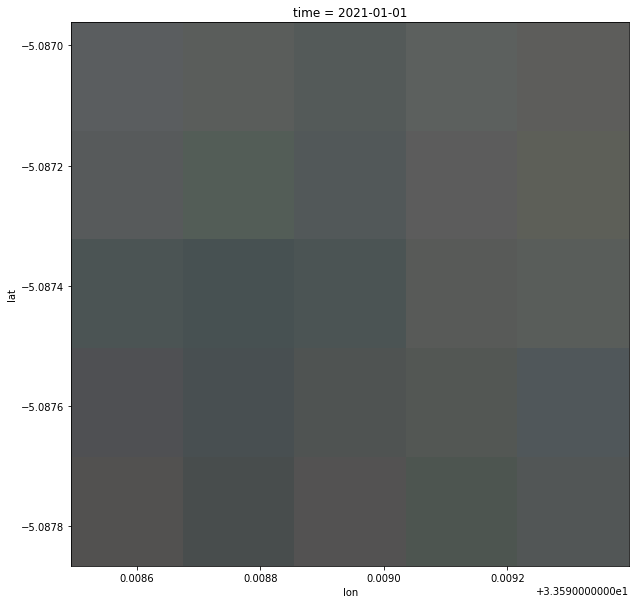

In [15]:
rgb_brightness_scaling=2

(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t) * rgb_brightness_scaling).plot.imshow(rgb="band", figsize = (10, 10))

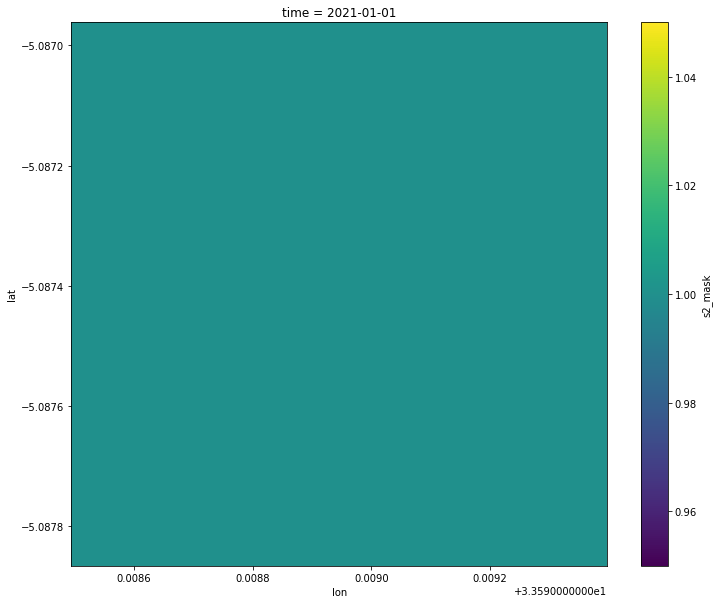

In [16]:
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t)*rgb_brightness_scaling).plot.imshow(rgb="band", figsize=(12,10))
cube["s2_mask"].isel(time=S2_t).where(lambda x: x>0).plot.imshow(ax = plt.gca())

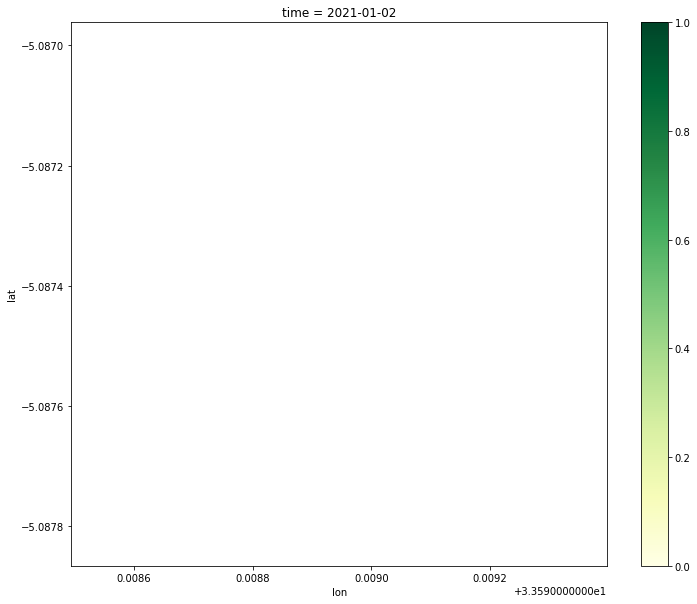

In [17]:
(4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=S1_t).plot.imshow(vmin = 0, vmax = 1,cmap = cmap_veg, figsize = (12, 10))

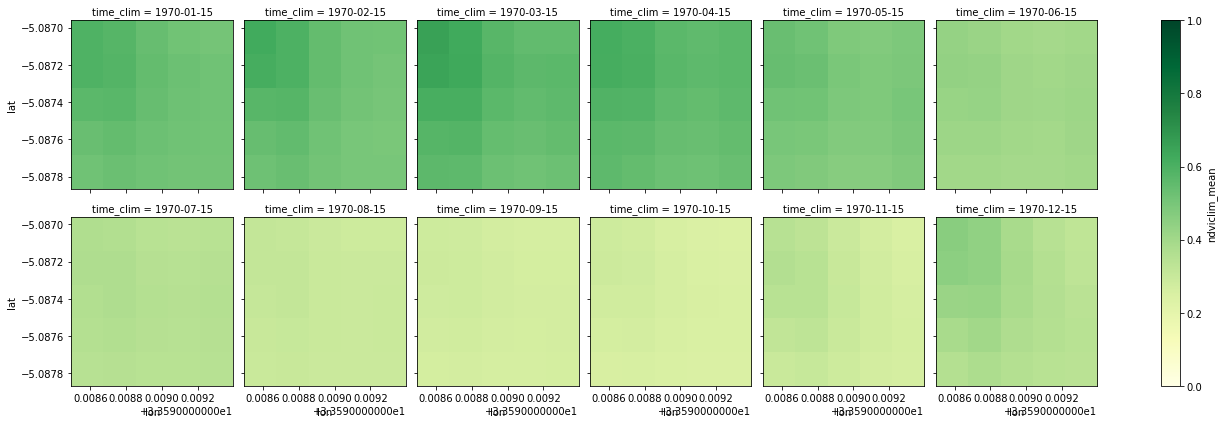

In [18]:
cube.ndviclim_mean.plot.imshow(col = "time_clim", col_wrap = 6, cmap = cmap_veg, vmin = 0, vmax = 1)

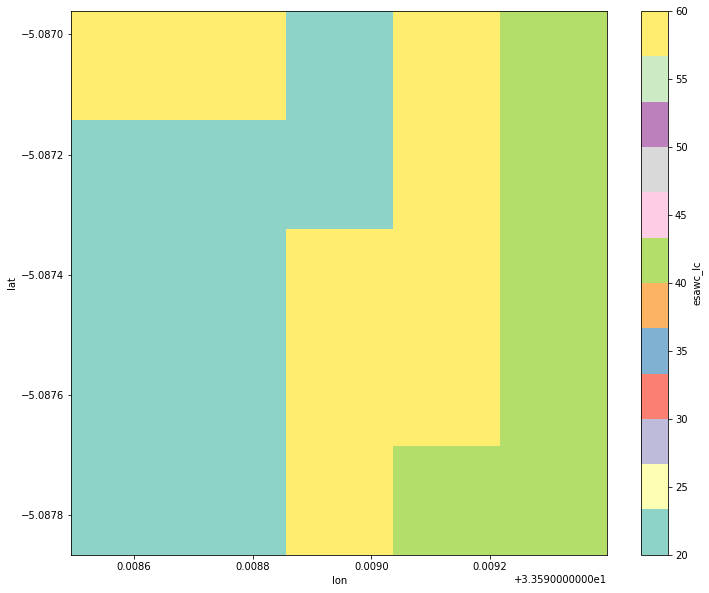

In [19]:
cube.esawc_lc.plot(cmap="Set3", figsize = (12, 10))

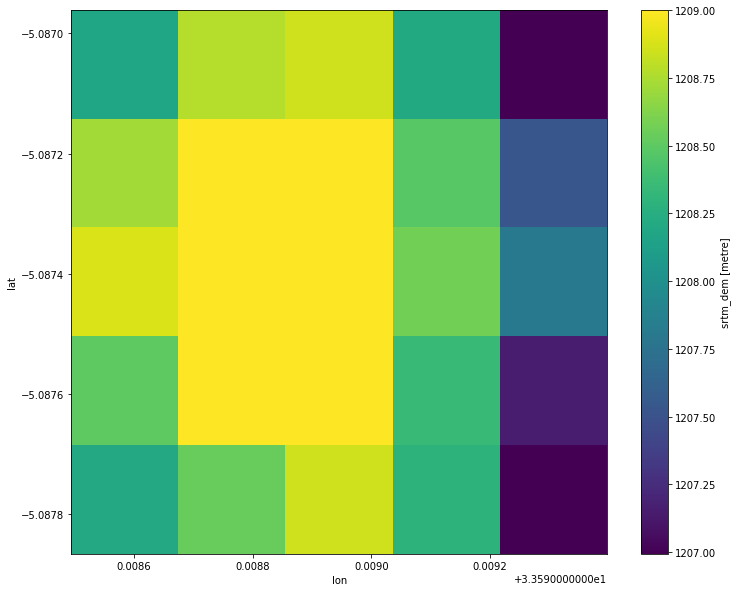

In [20]:
cube.srtm_dem.plot.imshow(figsize = (12, 10))

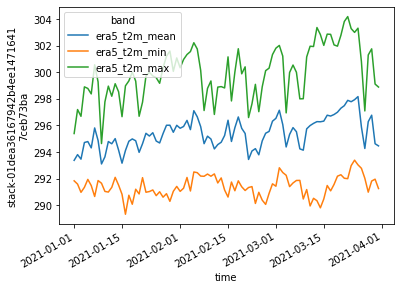

In [21]:
cube[["era5_t2m_mean","era5_t2m_min","era5_t2m_max"]].to_array("band").plot(hue = "band")